In [1]:
import os
import pandas as pd
import datetime as dt
from tqdm import tqdm
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
metadata = pd.read_csv("data/STAR_1k_metadata.csv", index_col=0)
metadata["star_start_timestamp"] = pd.to_datetime(metadata["star_start_time"]).apply(lambda x: int(x.timestamp()))
metadata["star_end_timestamp"] = pd.to_datetime(metadata["star_end_time"]).apply(lambda x: int(x.timestamp()))
metadata["star [s]"] = metadata["star_end_timestamp"] - metadata["star_start_timestamp"]
metadata["fastq_filesize_[GiB]"] = metadata["fastq_filesize_bytes"] / 1024 ** 3
metadata["fastq_filesize_[GiB]"] = metadata["fastq_filesize_[GiB]"].round(1)

In [3]:
def parse_log_progress_out_to_df(filepath):
    srr_id = filepath.split("_")[0]

    with open(filepath, "r") as file:
        lines = file.readlines()[2:-1]  # Skip two-line header and "ALL DONE!" and the end

    # Parse progress lines to list
    for i, line in enumerate(lines):
        date_string = "2024 " + line[:15]
        date_format = "%Y %b %d %H:%M:%S"
        datetime_object = dt.datetime.strptime(date_string, date_format)
        timestamp = datetime_object.timestamp()

        line = str(int(timestamp)) + line[15:]
        line = ','.join(filter(None, line.split(' '))).rstrip('\n')
        lines[i] = line

    # Create DataFrame from list
    headers = ["Time", "Speed M/hr", "Read number", "Read length", "Mapped unique %", "Mapped length", "Mapped MMrate","Mapped multi", "Unmapped multi+", "Unmapped MM", "Unmapped short", "Unmapped other"]
    df_progress = pd.read_csv(StringIO('\n'.join(lines)), names=headers)[["Time", "Speed M/hr", "Read number", "Mapped unique %"]]  # NOQA
    df_progress["Mapped unique %"] = df_progress["Mapped unique %"].apply(lambda x: x.replace('%', '')).astype(float)

    # Add start and end progress line
    srr_id_metadata = metadata.loc[metadata['SRR_id'] == srr_id]
    start_row = pd.DataFrame({'Time': srr_id_metadata["star_start_timestamp"], 'Speed M/hr': pd.NA, "Read number": 0, "Mapped unique %": pd.NA})
    end_row = pd.DataFrame({'Time': srr_id_metadata["star_end_timestamp"], 'Speed M/hr': pd.NA, "Read number": srr_id_metadata["n_spots"], "Mapped unique %": srr_id_metadata["STAR_mapping_rate [%]"].round(1)})

    return pd.concat([start_row, df_progress, end_row]).reset_index(drop=True)

### Finding ids for early stopping

In [4]:
dir_path = "data/log_progress"

es_data = []
mr_data = []

for file_name in tqdm(os.listdir(dir_path)):
    df = parse_log_progress_out_to_df(os.path.join(dir_path, file_name))

    if len(df) == 0:
        continue

    srr_id = file_name.split("_")[0]
    mr_data.append((srr_id, df["Mapped unique %"].min(), df["Mapped unique %"].max()))

    n_spots = df["Read number"][len(df) - 1]

    df_10up = df[df["Read number"] > 0.1 * n_spots]
    df_10up = df_10up.reset_index(drop=True)

    if any(df_10up["Mapped unique %"] < 30):
        es_data.append((srr_id, df_10up.iloc[-1]["Time"] - df_10up[df_10up["Mapped unique %"] < 30].iloc[0]["Time"]))

100%|██████████| 1000/1000 [00:09<00:00, 106.55it/s]


In [5]:
df_mr = pd.DataFrame(mr_data, columns=["SRR_id", "min_mr [%]", "max_mr [%]"])

df_es = pd.DataFrame(es_data, columns=["SRR_id", "wasted_time [s]"])
df_es = df_es.merge(right=metadata[["SRR_id", "star [s]", "fastq_filesize_[GiB]"]], how="inner", on="SRR_id").sort_values("fastq_filesize_[GiB]")

In [6]:
print(f"Number of files valid for early stopping: {len(df_es)}")
total_star_workload_time = metadata["star [s]"].sum()
total_wasted_time = df_es["wasted_time [s]"].sum()
prc_savings = (total_wasted_time / total_star_workload_time).round(4) * 100
print(f"Possible time save by early stopping feature: {prc_savings}%")

Number of files valid for early stopping: 38
Possible time save by early stopping feature: 19.48%


In [7]:
df_es

,SRR_id,wasted_time [s],star [s],fastq_filesize_[GiB]
24,SRR16541645,0.0,117,1.6
29,SRR16541689,73.0,178,1.6
25,SRR16541650,0.0,118,1.6
20,SRR16541597,135.0,201,1.9
28,SRR16541684,128.0,218,2.1
21,SRR16541602,124.0,243,2.3
18,SRR16541568,133.0,257,2.5
30,SRR16541695,141.0,256,2.5
22,SRR16541622,195.0,297,2.9
23,SRR16541635,120.0,212,3.0


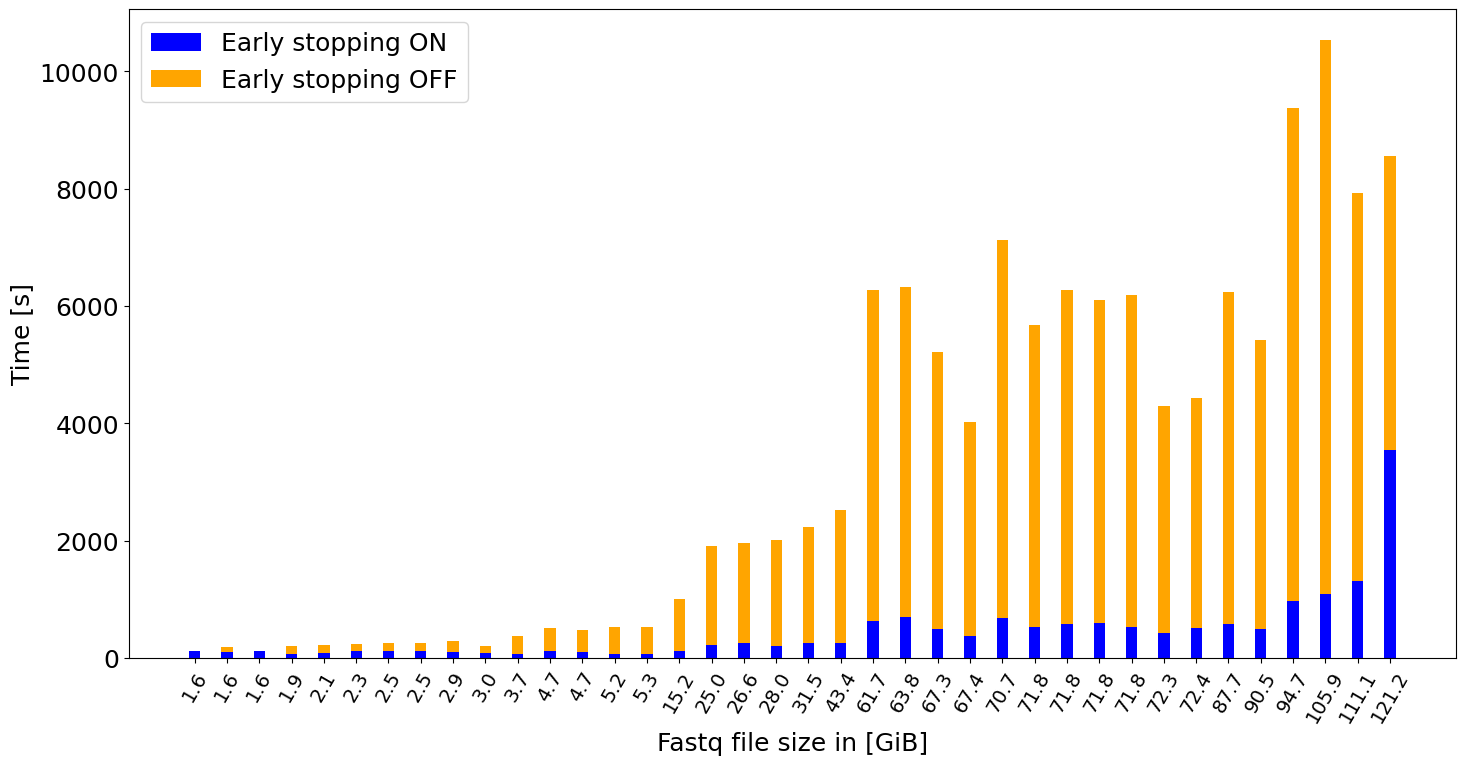

In [8]:
mpl.rcParams.update({'font.size': 18})
bar_width = 0.35

index = range(len(df_es))
plt.figure(figsize=(15, 8))

plt.bar(index, df_es['star [s]'] - df_es['wasted_time [s]'], bar_width, label='Early stopping ON', color='blue')
plt.bar(index, df_es['wasted_time [s]'], bar_width, bottom=df_es['star [s]'] - df_es['wasted_time [s]'],label='Early stopping OFF', color='orange')

# plt.title('Time savings by using early stopping (for inputs that result in low mapping rate).')
plt.xlabel('Fastq file size in [GiB]')
plt.ylabel('Time [s]')
plt.xticks(index, df_es['fastq_filesize_[GiB]'], rotation=60, fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig("early_stopping.pdf", format="pdf")
plt.show()

In [9]:
### All identified ids fall below 30.5% mapping rate
x = set(metadata[metadata['SRR_id'].isin(df_es["SRR_id"])]["SRR_id"])
y = set(metadata[metadata["STAR_mapping_rate [%]"] < 30.5]["SRR_id"])
assert x == y

### Change in mapping rate during alignment

In [10]:
df_mr["mr_diff"] = df_mr["max_mr [%]"] - df_mr["min_mr [%]"]
df_mr = df_mr.merge(right=metadata[["SRR_id", "STAR_mapping_rate [%]", "fastq_filesize_[GiB]"]], how="inner", on="SRR_id")

#### Low mapping rate ids

In [11]:
df_mr[df_mr["STAR_mapping_rate [%]"] < 30.5].describe()

,min_mr [%],max_mr [%],mr_diff,STAR_mapping_rate [%],fastq_filesize_[GiB]
count,38.000000,38.000000,38.000000,38.000000,38.000000
mean,12.268421,20.407895,8.139474,14.445789,41.821053
std,6.475196,11.879676,8.197348,5.741243,38.576096
min,0.200000,0.900000,0.000000,0.930000,1.600000
25%,7.175000,12.850000,3.225000,11.942500,3.175000
50%,12.150000,18.950000,4.900000,14.775000,29.750000
75%,15.975000,22.375000,9.325000,16.050000,71.800000
max,27.200000,58.600000,33.700000,30.270000,121.200000


In [12]:
print(f'Mean mapping rate difference for low-mr ids: {df_mr[df_mr["STAR_mapping_rate [%]"] < 30.5]["mr_diff"].mean().round(2)}')
print(f'Standard dev of mapping rate difference for low-mr ids: {df_mr[df_mr["STAR_mapping_rate [%]"] < 30.5]["mr_diff"].std().round(2)}')

Mean mapping rate difference for low-mr ids: 8.14
Standard dev of mapping rate difference for low-mr ids: 8.2


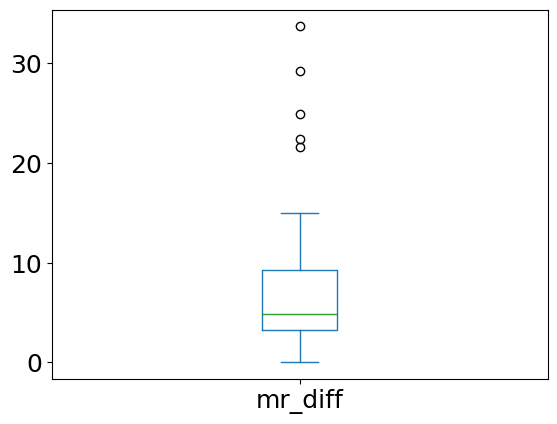

In [13]:
df_mr[df_mr["STAR_mapping_rate [%]"] < 30.5]["mr_diff"].plot.box();

#### High mapping-rate ids

In [14]:
df_mr[df_mr["STAR_mapping_rate [%]"] > 30.5].describe()

,min_mr [%],max_mr [%],mr_diff,STAR_mapping_rate [%],fastq_filesize_[GiB]
count,876.000000,876.000000,876.000000,876.000000,876.000000
mean,79.228196,79.515068,0.286872,79.353196,16.645205
std,11.532696,11.410661,0.943404,11.399853,15.157197
min,30.500000,30.600000,0.000000,30.580000,0.000000
25%,74.100000,74.275000,0.000000,74.287500,6.175000
50%,82.350000,82.650000,0.100000,82.460000,12.550000
75%,88.200000,88.400000,0.200000,88.232500,21.525000
max,94.700000,96.300000,16.100000,94.750000,145.400000


In [15]:
print(f'Mean mapping rate difference for high-mr ids: {df_mr[df_mr["STAR_mapping_rate [%]"] > 30.5]["mr_diff"].mean().round(2)}')
print(f'Standard dev of mapping rate difference for high-mr ids: {df_mr[df_mr["STAR_mapping_rate [%]"] > 30.5]["mr_diff"].std().round(2)}')

Mean mapping rate difference for high-mr ids: 0.29
Standard dev of mapping rate difference for high-mr ids: 0.94


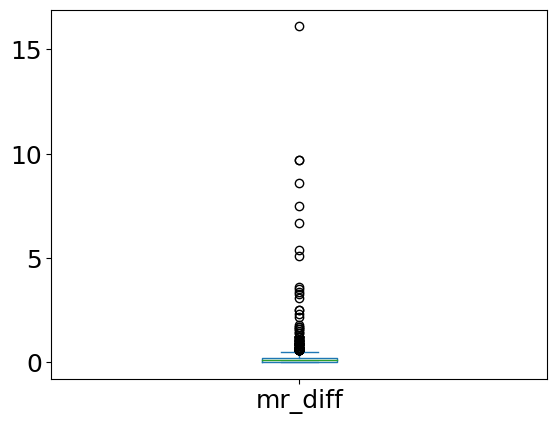

In [16]:
df_mr[df_mr["STAR_mapping_rate [%]"] > 30.5]["mr_diff"].plot.box();